This notebook is to test the codes for the new M-class flares list

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
from datetime import datetime as dt_obj, timedelta
import drms
import matplotlib.dates as mdates
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import pandas as pd
pd.set_option('display.max_rows', None)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [2]:
# import the final table of geomagnetic storms
path = './data/csv'
filename = 'M-class-flares_SC24.csv'
df_table = pd.read_csv(f'{path}/{filename}')

In [3]:
# show the names of columns
print(df_table.columns)

Index(['year', 'month', 'day', 'onset', 'peak', 'end', 'M-class', 'latitude',
       'Longitude', 'location', 'Confinement', 'AR', 'Sunspot type',
       'CME time', 'CME speed', 'CME AW', 'CME MPA', 'Jp 25 MeV', 'Je low',
       'DH type III', 'Rise/Decline', 'DH type II', 'class'],
      dtype='object')


In [4]:
df_table.head()

,year,month,day,onset,peak,end,M-class,latitude,Longitude,location,...,CME time,CME speed,CME AW,CME MPA,Jp 25 MeV,Je low,DH type III,Rise/Decline,DH type II,class
0,2010,1,19,13:03,13:41,13:50,2.3,-25,-88,S25E88,...,14:06u,153,44,101,no,no,no,no,no,M2.3
1,2010,1,19,20:23,20:35,20:46,1.7,-25,-88,S25E88,...,no,no,no,no,no,no,occulted,decline,no,M1.7
2,2010,1,20,06:45,07:27,07:34,1.0,-24,-87,S24E87,...,no,no,no,no,no,no,no,no,no,M1.0
3,2010,1,20,07:42,07:49,07:53,1.6,-24,-88,S24E88,...,no,no,no,no,no,no,no,no,no,M1.6
4,2010,1,20,10:46,10:59,11:10,1.8,-25,-87,S25E87,...,11:30u,101,46,99,no,no,no,no,no,M1.8


In [22]:
def create_datetime(row):
    """
    Make a datetime column from a row in a dataframe.
    """
    yyyy = int(row['year'])
    mm = int(row['month'])
    dd = int(row['day'])
    flare_onset = row['onset']
    time = dt_obj.strptime(flare_onset, '%H:%M')
    return dt_obj(yyyy, mm, dd, time.hour, time.minute)


def parse_tai_string(time_str, datetime_obj=True):
    """
    Convert the keyword `T_REC` into a datetime object.
    """
    year   = int(time_str[:4])
    month  = int(time_str[5:7])
    day    = int(time_str[8:10])
    hour   = int(time_str[11:13])
    minute = int(time_str[14:16])
    if datetime_obj:
        return dt_obj(year, month, day, hour, minute)
    else:
        return year, month, day, hour, minute

In [23]:
# add a datetime column for the flare onset time
df_table['datetime_flare_onset'] = df_table.apply(create_datetime, axis=1)

In [27]:
# Extract only the integer part
df_table['AR'] = df_table['AR'].str.extract('(\d+)')
# Remove any non-digit or non-colon characters
df_table['CME time'] = df_table['CME time'].str.replace(r'[^0-9:]', '', regex=True)

In [25]:
# Split the DataFrame based on "Confinement" column
df_table_yes = df_table[df_table['Confinement'] == 'yes']
df_table_no = df_table[df_table['Confinement'] == 'no']

In [26]:
print(f'Total number of flares: {len(df_table)}')
print(f'Number of confined flares: {len(df_table_yes)}')
print(f'Number of unconfined flares: {len(df_table_no)}')
print(f'Number of confined & unconfined flares: {len(df_table_yes)+len(df_table_no)}')
print(f'Number of uncertain flares: {len(df_table)-(len(df_table_yes)+len(df_table_no))}')

Total number of flares: 749
Number of confined flares: 351
Number of unconfined flares: 326
Number of confined & unconfined flares: 677
Number of uncertain flares: 72


In [30]:
c = drms.Client()
c.series(r'hmi\.sharp_')

['hmi.sharp_720s',
 'hmi.sharp_720s_dconS',
 'hmi.sharp_720s_nrt',
 'hmi.sharp_cea_720s',
 'hmi.sharp_cea_720s_dconS',
 'hmi.sharp_cea_720s_nrt']

### Select which row (event) to work with

In [32]:
event_index = 3

dt_window = 12 # +/- dt time in hours
data_type = 'hmi.sharp_cea_720s'
si = c.info(data_type) # Set a series

noaa_ar =  df_table['AR'][event_index]
flare_onset_datetime = df_table['datetime_flare_onset'][event_index]
end_year, end_month, end_day  = str(flare_onset_datetime.date()).split('-')
end_hour, end_minute, end_sec = str(flare_onset_datetime.time()).split(':')

start_datetime = flare_onset_datetime - timedelta(hours=dt_window)
start_year, start_month, start_day  = str(start_datetime.date()).split('-')
start_hour, start_minute, start_sec = str(start_datetime.time()).split(':')

print(f'NOAA AR No.: {noaa_ar}')
print(f'SHARP dataset: {data_type}\n')

print(f'Start datetime: {start_datetime}')
print(f'Start year: {start_year}')
print(f'Start month: {start_month}')
print(f'Start day: {start_day}')
print(f'Start hour: {start_hour}')
print(f'Start minute: {start_minute}\n')

print(f'End datetime: {flare_onset_datetime}')
print(f'End year: {end_year}')
print(f'End month: {end_month}')
print(f'End day: {end_day}')
print(f'End hour: {end_hour}')
print(f'End minute: {end_minute}\n')

NOAA AR No.: 11041
SHARP dataset: hmi.sharp_cea_720s

Start datetime: 2010-01-19 19:42:00
Start year: 2010
Start month: 01
Start day: 19
Start hour: 19
Start minute: 42

End datetime: 2010-01-20 07:42:00
End year: 2010
End month: 01
End day: 20
End hour: 07
End minute: 42



In [33]:
sharp_starttime = pd.to_datetime(f'{start_year}.{start_month}.{start_day} {start_hour}:{start_minute}')
# add a time offset to get full SHARP timeseries data that covers the flare end time
sharp_endtime   = pd.to_datetime(f'{end_year}.{end_month}.{end_day} {end_hour}:{end_minute}') + timedelta(hours=2)

print(f'Data type: {data_type}')
print(f'SHARP start time: {sharp_starttime}')
print(f'SHARP end time: {sharp_endtime}')
print(f'AR No.: {noaa_ar}')

keys = c.query(f'{data_type}[][{sharp_starttime} - {sharp_endtime}][? NOAA_ARS ~ "{noaa_ar}" ?]',
                      key='T_REC, HARPNUM, NOAA_ARS, USFLUX, MEANGAM, MEANGBT, MEANGBZ, MEANGBH, MEANJZD, TOTUSJZ,\
                        MEANALP, MEANJZH, TOTUSJH, ABSNJZH, SAVNCPP, MEANPOT, TOTPOT, MEANSHR, R_VALUE')
if len(keys) == 0:
    print('No SHARP data found!')
else:
    print(f'SHARP data found! --> length: {len(keys)}')

Data type: hmi.sharp_cea_720s
SHARP start time: 2010-01-19 19:42:00
SHARP end time: 2010-01-20 09:42:00
AR No.: 11041
No SHARP data found!


In [16]:
# # Find more information about the FITS header keywords that belong to any given series
# si.keywords

In [17]:
# # See all the segments associated with the series
# si.segments

In [35]:
# run a for loop to identify the events indicies that have SHARP data available
event_indices_with_sharp_data    = []
event_indices_without_sharp_data = []

with tqdm(total=len(df_table), desc=f'Loading events info ...') as pbar:
    for event_index in range(len(df_table)):
        si = c.info(data_type) # Set a series
        noaa_ar =  df_table['AR'][event_index]
        flare_onset_datetime = df_table['datetime_flare_onset'][event_index]
        flare_onset_date = str(flare_onset_datetime.date()).split('-')
        flare_onset_time = str(flare_onset_datetime.time()).split(':')

        end_year = flare_onset_date[0]
        end_month = flare_onset_date[1]
        end_day = flare_onset_date[2]

        end_hour = flare_onset_time[0]
        end_minute = flare_onset_time[1]

        dt_window = 12 # +/- dt time in hours

        start_datetime = flare_onset_datetime - timedelta(hours=dt_window)
        start_date = str(start_datetime.date()).split('-')
        start_time = str(start_datetime.time()).split(':')

        start_year = start_date[0]
        start_month = start_date[1]
        start_day = start_date[2]

        start_hour = start_time[0]
        start_minute = start_time[1]
        
        sharp_starttime = pd.to_datetime(f'{start_year}.{start_month}.{start_day} {start_hour}:{start_minute}')
        # add a time offset to get full SHARP timeseries data that covers the flare end time
        sharp_endtime   = pd.to_datetime(f'{end_year}.{end_month}.{end_day} {end_hour}:{end_minute}') + timedelta(hours=2)

        keys = c.query(f'{data_type}[][{sharp_starttime} - {sharp_endtime}][? NOAA_ARS ~ "{noaa_ar}" ?]',
                            key='T_REC, HARPNUM, NOAA_ARS, USFLUX, MEANGAM, MEANGBT, MEANGBZ, MEANGBH, MEANJZD, TOTUSJZ, MEANALP,\
                                MEANJZH, TOTUSJH, ABSNJZH, SAVNCPP, MEANPOT, TOTPOT, MEANSHR, R_VALUE')
        if len(keys) == 0:
            # print(f'No SHARP data found for event index --> {event_index}')
            event_indices_without_sharp_data.append(event_index)
            pass
        else:
            # print(f'SHARP data found! --> {event_index} length: {len(keys)}')
            event_indices_with_sharp_data.append(event_index)
        pbar.update(1)

print(len(df_table))
print(len(event_indices_without_sharp_data))
print(len(event_indices_with_sharp_data))
print(event_indices_without_sharp_data)

Loading events info ...: 100%|██████████| 749/749 [12:54<00:00,  1.03s/it]

749
55
694
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 178, 231, 232, 243, 244, 245, 248, 280, 282, 283, 337, 347, 421, 469, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 493, 494, 495, 496, 500, 501, 512, 589, 615, 622, 688, 707, 717]


In [19]:
display(keys['T_REC'].head(3))
display(keys['T_REC'].tail(3))

0    2010.07.31_20:00:00_TAI
1    2010.07.31_20:12:00_TAI
2    2010.07.31_20:24:00_TAI
Name: T_REC, dtype: object

68    2010.08.01_09:36:00_TAI
69    2010.08.01_09:48:00_TAI
70    2010.08.01_10:00:00_TAI
Name: T_REC, dtype: object

In [36]:
t_rec = np.array([parse_tai_string(keys.T_REC[i], datetime_obj=True) for i in range(keys.T_REC.size)])

In [37]:
# Show a sample for validation purposes
print(f'First few samples:\n{t_rec[:3]}\n')
print(f'Last few samples:\n{t_rec[-3:]}')

First few samples:
[datetime.datetime(2017, 10, 20, 22, 48)
 datetime.datetime(2017, 10, 20, 23, 0)
 datetime.datetime(2017, 10, 20, 23, 12)]

Last few samples:
[datetime.datetime(2017, 10, 21, 0, 48)
 datetime.datetime(2017, 10, 21, 1, 0)
 datetime.datetime(2017, 10, 21, 1, 12)]


Flare onset: 2017-10-20 23:10:00
Flare peak: 2017-10-20 23:28:00
Flare end: 2017-10-20 23:37:00

Flare rise time: 18.0 min.
Flare decend time: 9.0 min.


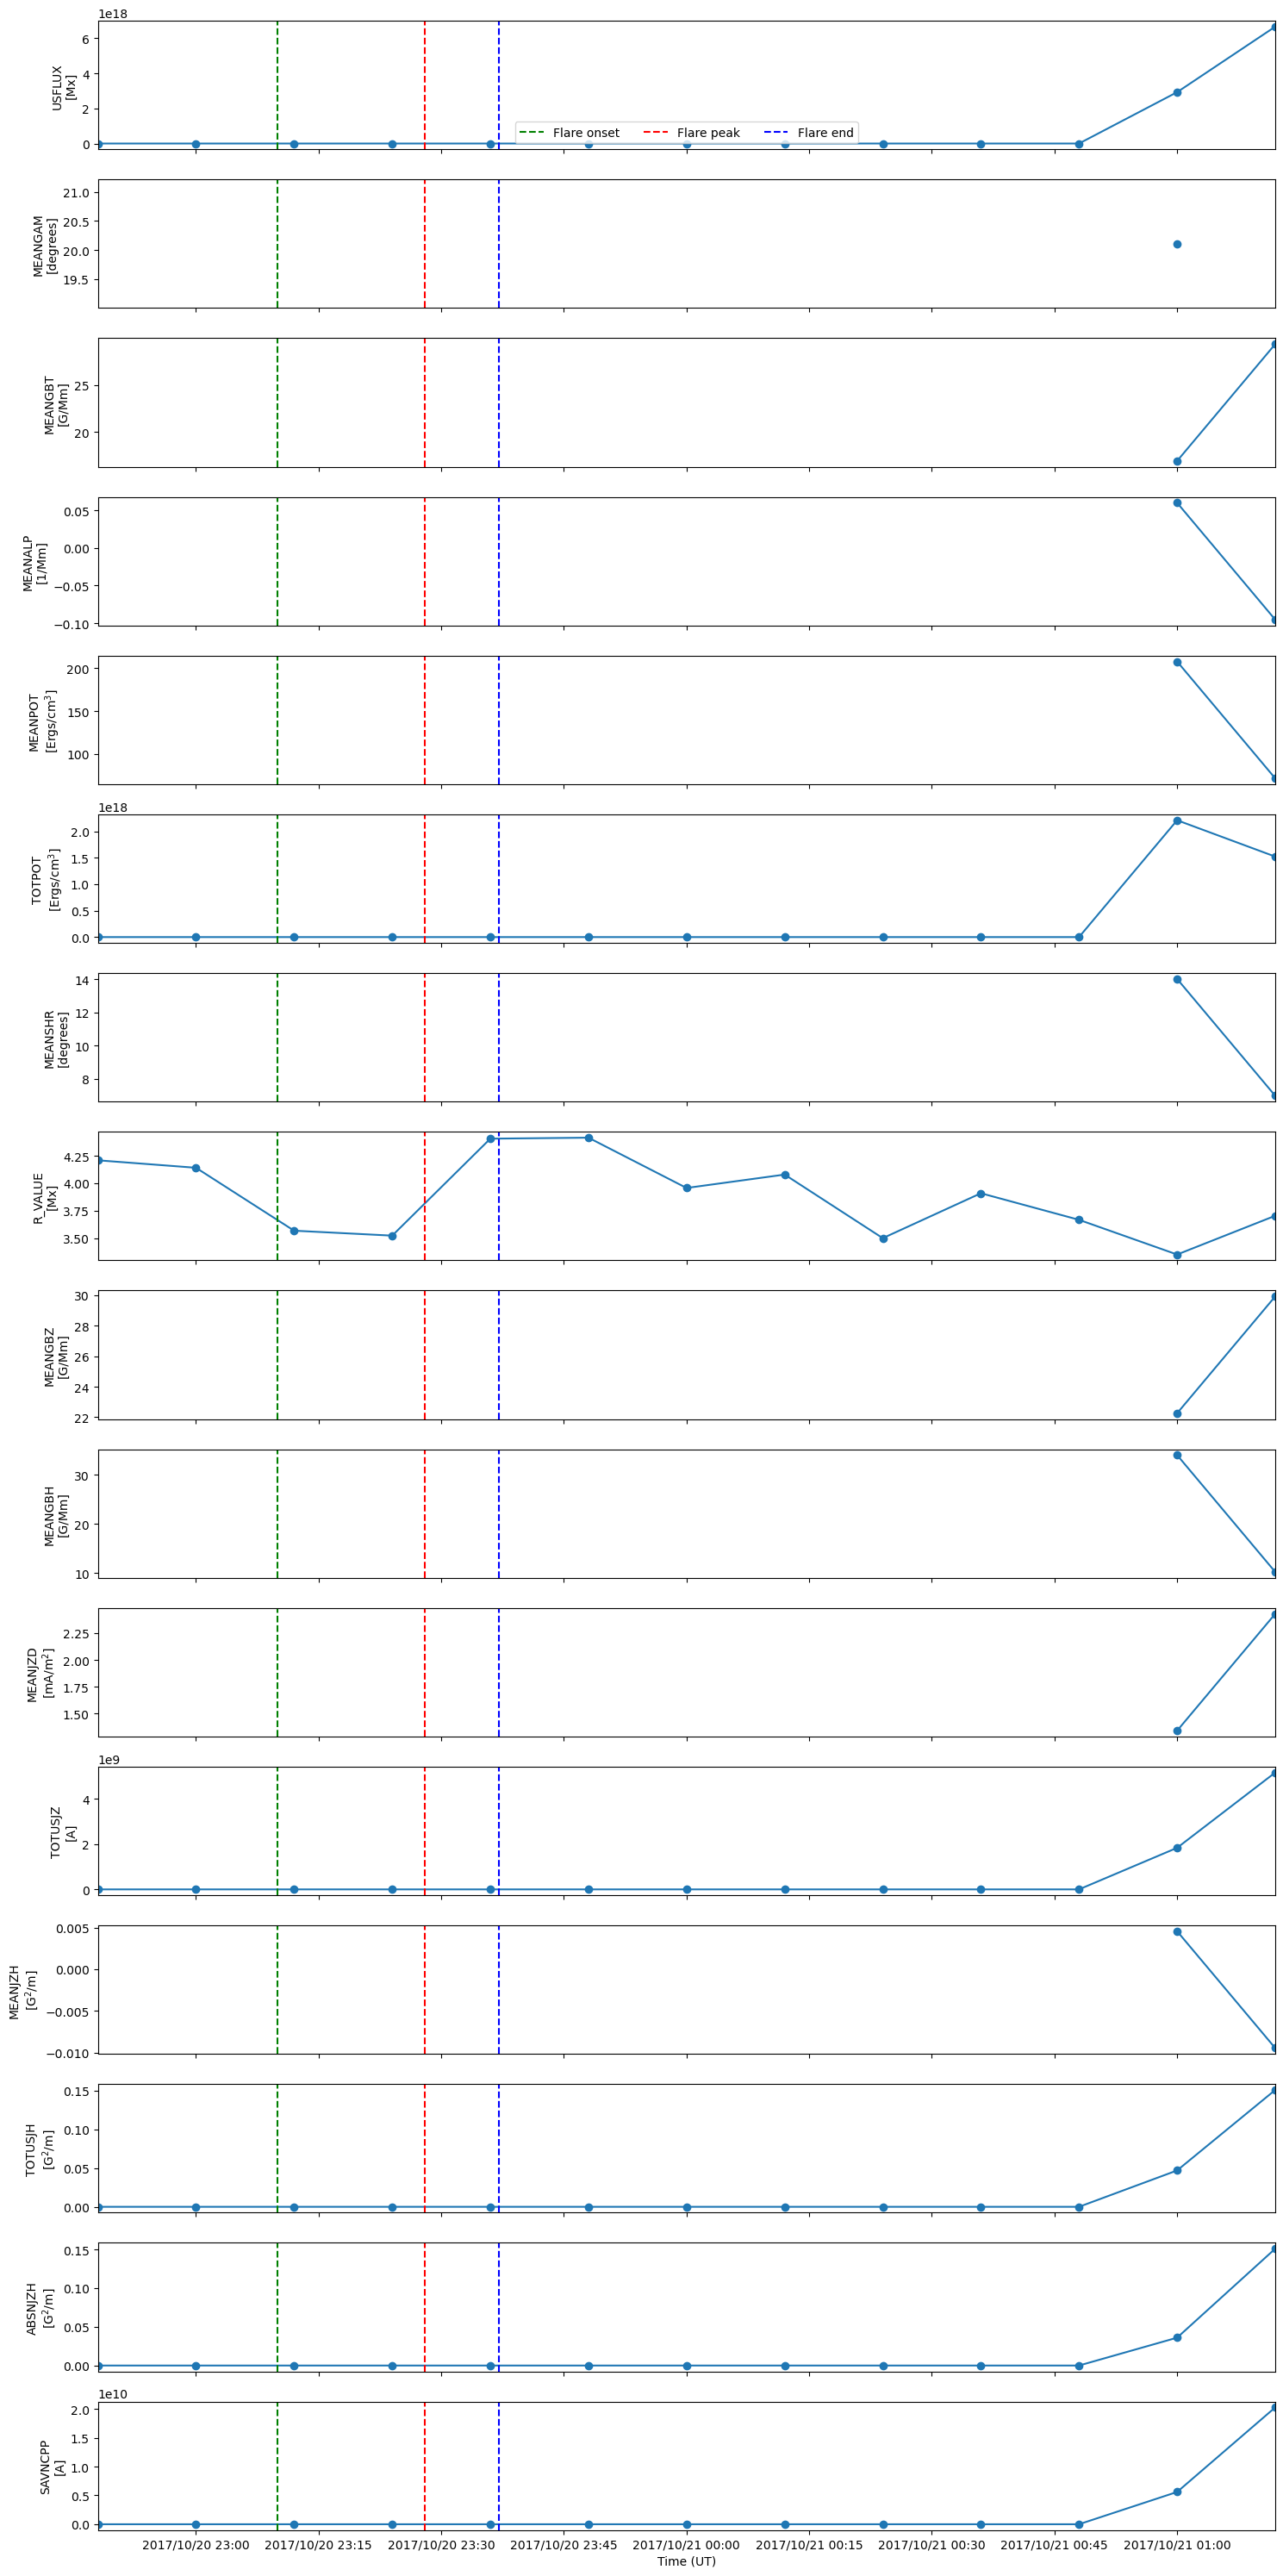

In [39]:
# Plot the choosen SHARP parameters in a for loop
chosen_parameters = {
    'USFLUX': 'USFLUX\n[Mx]',
    'MEANGAM': 'MEANGAM\n[degrees]',
    'MEANGBT': 'MEANGBT\n[G/Mm]',
    'MEANALP': 'MEANALP\n[1/Mm]',
    'MEANPOT': 'MEANPOT\n[Ergs/cm$^3$]',
    'TOTPOT': 'TOTPOT\n[Ergs/cm$^3$]',
    'MEANSHR': 'MEANSHR\n[degrees]',
    'R_VALUE': 'R_VALUE\n[Mx]',
    'MEANGBZ': 'MEANGBZ\n[G/Mm]',
    'MEANGBH': 'MEANGBH\n[G/Mm]',
    'MEANJZD': 'MEANJZD\n[mA/m$^2$]',
    'TOTUSJZ': 'TOTUSJZ\n[A]',
    'MEANJZH': 'MEANJZH\n[G$^2$/m]',
    'TOTUSJH': 'TOTUSJH\n[G$^2$/m]',
    'ABSNJZH': 'ABSNJZH\n[G$^2$/m]',
    'SAVNCPP': 'SAVNCPP\n[A]'
}

flare_peak_moment = pd.to_datetime(f"{flare_onset_datetime.date()} {df_table['peak'][event_index]}")
flare_end_moment  = pd.to_datetime(f"{flare_onset_datetime.date()} {df_table['end'][event_index]}")

if flare_peak_moment < flare_onset_datetime:
    flare_peak_moment += timedelta(days=1)

if flare_end_moment < flare_peak_moment or flare_end_moment < flare_onset_datetime:
    flare_end_moment += timedelta(days=1)

print(f'Flare onset: {flare_onset_datetime}')
print(f'Flare peak: {flare_peak_moment}')
print(f'Flare end: {flare_end_moment}')

dt_rise = (flare_peak_moment - flare_onset_datetime).total_seconds()/60
dt_dec  = (flare_end_moment - flare_peak_moment).total_seconds()/60

print(f'\nFlare rise time: {dt_rise} min.')
print(f'Flare decend time: {dt_dec} min.')

fig = plt.figure(figsize=[15,30])

for i, (col, unit) in enumerate(chosen_parameters.items()):
    ax = fig.add_subplot(len(chosen_parameters), 1, i+1)
    ax.plot(t_rec, keys[col], 'o-')
    ax.axvline(x=flare_onset_datetime, color='g', linestyle='--', label='Flare onset')
    ax.axvline(x=flare_peak_moment, color='r', linestyle='--', label='Flare peak')
    ax.axvline(x=flare_end_moment, color='b', linestyle='--', label='Flare end')
    ax.set_ylabel(unit)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d %H:%M'))
    ax.set_xlim(left=t_rec[0], right=t_rec[-1])
    
    if i == 0:
        ax.legend(loc='best', ncol=3)
        ax.set_xticklabels([])
    elif i != len(chosen_parameters) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (UT)')

fig.tight_layout()
plt.show()

In [75]:
# fig.savefig(f'./{str(flare_onset_datetime.date())}.pdf', format='pdf', bbox_inches='tight')

Prepare the coorelation tables

In [76]:
# === MAKE THESE TABLES AND EXPORT THEM ===
# corr_matrix_0    : first point (of each SHARP parameter) before the flare onset time.
# corr_matrix_rise : avg value (of each SHARP parameter) from the flare onset to peak time.
# corr_matrix_dec  : avg value (of each SHARP parameter) from the flare peak to end time.
# corr_matrix_all  : avg value (of each SHARP parameter) from the flare onset to end time.

In [32]:
# set the keys datetime as the index column
keys['datetimes'] = t_rec
try:
    keys.drop('T_REC', axis=1, inplace=True)
except:
    pass
keys.index = keys['datetimes']

display(keys.head(3))

,HARPNUM,NOAA_ARS,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
datetimes,,,,,,,,,,,,,,,,,,,
2010-07-31 20:00:00,104,11092,1.726530e+22,45.435,88.857,90.077,45.191,0.320187,2.075802e+13,-0.015136,-0.007582,956.694,196.398,7.103441e+12,12132.23,4.173370e+23,39.841,3.980,2010-07-31 20:00:00
2010-07-31 20:12:00,104,11092,1.715229e+22,45.081,89.045,90.606,45.346,0.358093,2.042032e+13,-0.014376,-0.007357,969.761,186.264,6.498671e+12,12464.06,4.191009e+23,39.703,3.954,2010-07-31 20:12:00
2010-07-31 20:24:00,104,11092,1.700083e+22,45.532,88.869,90.740,45.285,0.334223,2.035284e+13,-0.014273,-0.007371,972.531,184.349,5.800525e+12,12690.71,4.215145e+23,39.915,4.041,2010-07-31 20:24:00


In [34]:
# take only these columns from the given table of events
df = df_table.filter(['datetime_flare_onset', 'Dst', 'CME_onset', 'CME_speed',
                    'CME_AW', 'MPA', 'Flare_onset', 'Flare_peak', 'Flare_end', 'C-class', 'lat', 'long',
                    'AR number', 'AR location', 'AR same day', 'AR next day'])
# df.set_index('datetime_flare_onset', drop=True)
df.index = df['datetime_flare_onset']
df.drop('datetime_flare_onset', axis=1, inplace=True)
display(df.head(3))

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_onset,Flare_peak,Flare_end,C-class
datetime_flare_onset,,,,,,,,,
2010-02-12 11:19:00,-59,12/13:42u,509,360,44u,11:19,11:26,11:28,83.00
2010-04-03 09:04:00,-81,03/10:34,668,360,171,9:04,9:54,10:58,0.74
2010-05-24 13:05:00,-80,24/14:06,427,360,280,13:05,14:46,15:50,0.11


### Get the first point (of each SHARP parameter) before the flare onset time ( `corr_matrix_0` )

In [35]:
# Get the index position of the flare_onset_datetime

# Check if the timestamp exists directly in the index
if flare_onset_datetime in keys.index:
    # Exact match found, get the position
    position = keys.index.get_loc(flare_onset_datetime)
    # Get the previous row if position is greater than 0, to avoid IndexError
    if position > 0:
        previous_row = keys.iloc[position - 1]
    else:
        previous_row = None  # Handle if it's the first row
else:
    # Use get_indexer to find the nearest timestamp before or equal to the target
    position = keys.index.get_indexer([flare_onset_datetime], method='pad')[0]
    # Check if the position is valid (it returns -1 if there’s no preceding match)
    if position != -1:
        # If a preceding timestamp is found, position will be non-negative
        if position > 0:
            previous_row = keys.iloc[position]
        else:
            previous_row = None  # It's the first row
    else:
        previous_row = None  # No timestamp before or equal to flare_onset_datetime

# display(previous_row)

# Combine the two rows from the two Dataframes
series1        = df.loc[flare_onset_datetime]
series2_0      = previous_row
combined_row_0 = pd.concat([series1, series2_0])

# Add the combined row to the final DataFrame
df_final_0 = pd.DataFrame(columns=combined_row_0.index)
df_final_0.loc[0] = combined_row_0

# export the dataframe
#######

display(df_final_0)

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_onset,Flare_peak,Flare_end,C-class,HARPNUM,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,-74,01/13:42,850,360,84,7:55,8:26,9:35,3.2,104,...,-0.014494,-0.007585,866.199,175.719,5637476000000.0,13645.76,419836500000000031326208.0,42.629,3.659,2010-08-01 07:48:00


In [36]:
# for event_index in range(len(df_table))[:3]:
#     print(event_index)

### Get the average value (of each SHARP parameter) from the flare onset to peak time ( `corr_matrix_rise` )

In [37]:
series2_rise = keys.loc[flare_onset_datetime:flare_peak_moment].mean(skipna=True)

# Combine the two rows from the two Dataframes
combined_row_rise = pd.concat([series1, series2_rise])

# Add the combined row to the final DataFrame
df_final_rise = pd.DataFrame(columns=combined_row_rise.index)
df_final_rise.loc[0] = combined_row_rise

# export the dataframe
#######

display(df_final_rise)

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_onset,Flare_peak,Flare_end,C-class,HARPNUM,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,-74,01/13:42,850,360,84,7:55,8:26,9:35,3.2,104.0,...,-0.014833,-0.007568,842.658667,178.646,5762117666666.666992,13373.626667,419191533333333338488832.0,42.912,3.618,2010-08-01 08:12:00


### Get the average value (of each SHARP parameter) from the flare peak to end time ( `corr_matrix_dec` )

In [38]:
series2_dec = keys.loc[flare_peak_moment:flare_end_moment].mean(skipna=True)

# Combine the two rows from the two Dataframes
combined_row_dec = pd.concat([series1, series2_dec])

# Add the combined row to the final DataFrame
df_final_dec = pd.DataFrame(columns=combined_row_dec.index)
df_final_dec.loc[0] = combined_row_dec

# export the dataframe
#######

display(df_final_dec)

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_onset,Flare_peak,Flare_end,C-class,HARPNUM,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,-74,01/13:42,850,360,84,7:55,8:26,9:35,3.2,104.0,...,-0.014327,-0.007036,853.4914,171.1198,6122750000000.0,13075.89,422339959999999974047744.0,43.1904,3.7044,2010-08-01 09:00:00


### Get the average value (of each SHARP parameter) from the flare onset to end time ( `corr_matrix_all` )

In [39]:
series2_all = keys.loc[flare_onset_datetime:flare_end_moment].mean(skipna=True)

# Combine the two rows from the two Dataframes
combined_row_all = pd.concat([series1, series2_all])

# Add the combined row to the final DataFrame
df_final_all = pd.DataFrame(columns=combined_row_all.index)
df_final_all.loc[0] = combined_row_all

# export the dataframe
#######

display(df_final_all)

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_onset,Flare_peak,Flare_end,C-class,HARPNUM,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,-74,01/13:42,850,360,84,7:55,8:26,9:35,3.2,104.0,...,-0.014517,-0.007236,849.429125,173.942125,5987512875000.0,13187.54125,421159299999999985713152.0,43.086,3.672,2010-08-01 08:42:00


1. loop over all the events
2. calc the 4 corr dfs and export them
3. import them one by one for plotting

### Check the correlartions

In [52]:
# import the final table

corr_filename = 'corr_matrix_0'
# corr_filename = 'corr_matrix_all'
# corr_filename = 'corr_matrix_dec'
# corr_filename = 'corr_matrix_rise'

# corr_filename = 'corr_matrix_cer' ... ?

# Load the data
df = pd.read_csv(f'{path}/{corr_filename}.csv')
df.head()

,Unnamed: 0,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_peak,Flare_end,C-class,lat,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,0,-74,01/13:42,850,360,84,8:26,9:35,3.2,20,...,-0.014494,-0.007585,866.199,175.719,5.637476e+12,13645.760,4.198365e+23,42.629,3.659,2010-08-01 07:48:00
1,1,-83,07/20:00u,2125,360,313,20:12,20:58,37.0,31,...,0.010848,0.005078,4026.154,455.828,2.469219e+13,8322.466,9.921369e+23,32.357,4.816,2011-03-07 19:36:00
2,2,-115,04/04:12,1315,360,298,3:57,4:04,93.0,19,...,0.048845,0.019993,2696.795,745.497,3.030290e+13,8596.312,4.257019e+23,38.658,4.706,2011-08-04 03:36:00


In [53]:
print(len(df), df.columns)

3 Index(['Unnamed: 0', 'Dst', 'CME_onset', 'CME_speed', 'CME_AW', 'MPA',
       'Flare_peak', 'Flare_end', 'C-class', 'lat', 'long', 'AR number',
       'AR location', 'AR same day', 'AR next day', 'HARPNUM', 'NOAA_ARS',
       'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR', 'R_VALUE', 'datetimes'],
      dtype='object')


In [54]:
# Drop unnecessary columns
df.drop(['Unnamed: 0','NOAA_ARS','lat','long','AR number','AR location','AR same day',
        'AR next day','datetimes','CME_onset','Flare_peak','Flare_end'], axis=1, inplace=True)

In [55]:
df

,Dst,CME_speed,CME_AW,MPA,C-class,HARPNUM,USFLUX,MEANGAM,MEANGBT,MEANGBZ,...,TOTUSJZ,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE
0,-74,850,360,84,3.2,104,1.527288e+22,48.412,88.037,88.951,...,1.875297e+13,-0.014494,-0.007585,866.199,175.719,5.637476e+12,13645.760,4.198365e+23,42.629,3.659
1,-83,2125,360,313,37.0,393,6.574974e+22,38.318,79.710,87.502,...,6.885035e+13,0.010848,0.005078,4026.154,455.828,2.469219e+13,8322.466,9.921369e+23,32.357,4.816
2,-115,1315,360,298,93.0,750,2.414682e+22,45.675,115.830,123.810,...,4.825637e+13,0.048845,0.019993,2696.795,745.497,3.030290e+13,8596.312,4.257019e+23,38.658,4.706


In [ ]:
# param_type = '0'

# chosen_parameters = ['Dst', 'CME_speed', 'CME_AW', 'flare_rise', 'flare_duration',
#         'SF_class', f'USFLUX-{param_type}', f'MEANGAM-{param_type}', f'MEANGBT-{param_type}',
#         f'MEANGBZ-{param_type}', f'MEANGBH-{param_type}', f'MEANJZD-{param_type}', f'TOTUSJZ-{param_type}',
#         f'MEANALP-{param_type}', f'MEANJZH-{param_type}', f'TOTUSJH-{param_type}', f'ABSNJZH-{param_type}',
#         f'SAVNCPP-{param_type}', f'MEANPOT-{param_type}', f'TOTPOT-{param_type}', f'MEANSHR-{param_type}',
#         f'R_VALUE-{param_type}']

# df = df[chosen_parameters]
# df.head()

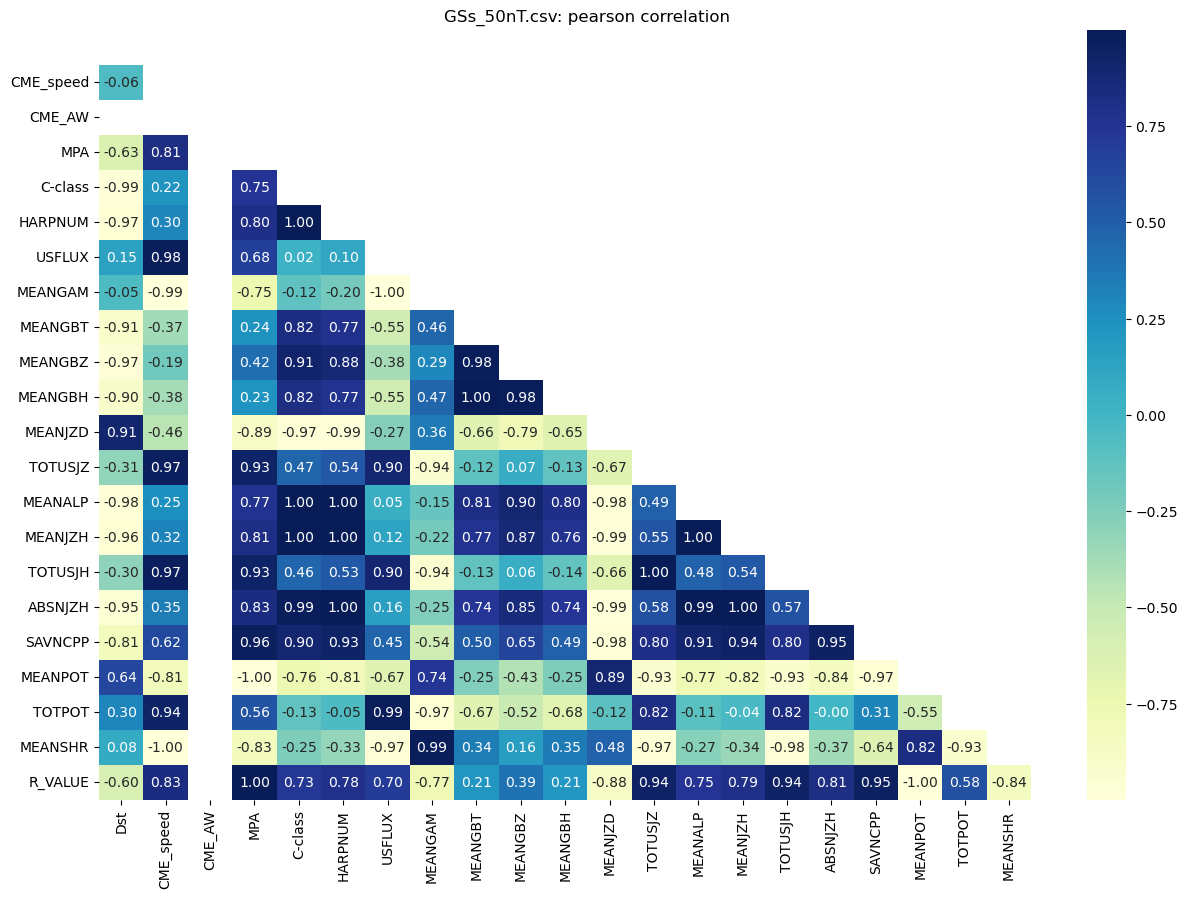

In [56]:
corr_method = 'pearson'

corr_matrix = df.corr(method=corr_method)

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)

# Make a triangular mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
m = sns.heatmap(corr_matrix, annot=True, annot_kws={'size':10}, fmt='.2f', ax=ax, mask=mask, cmap='YlGnBu', cbar=True, cbar_kws={'pad':0.01})
m.set_title(f'{filename}: {corr_method} correlation')
m.set_xticks(m.get_xticks()[:-1])[:-1]
m.set_yticks(m.get_yticks()[1:])[1:]
# fig.savefig(f'./{filename}_{corr_method}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

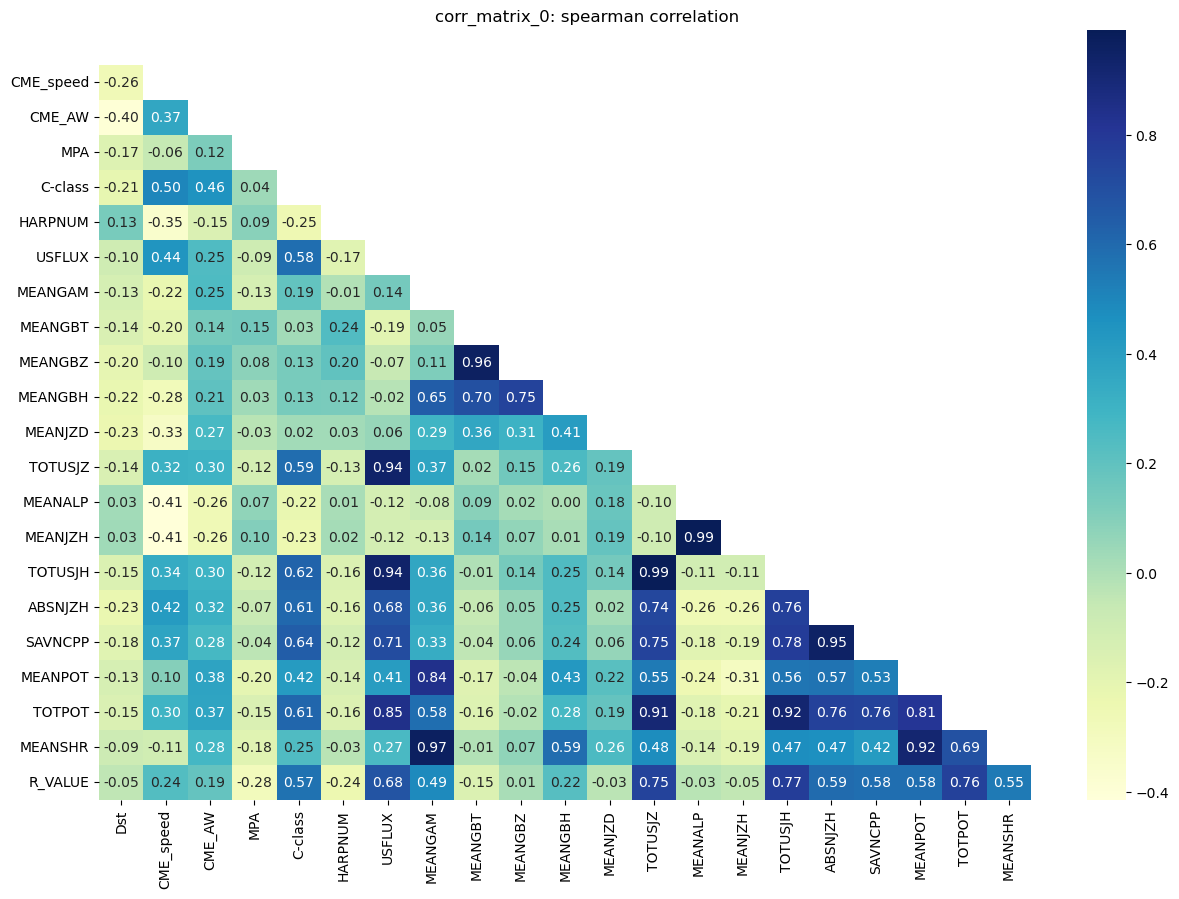

In [104]:
corr_method = 'spearman'

corr_matrix = df.corr(method=corr_method)

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)

# Make a triangular mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
m = sns.heatmap(corr_matrix, annot=True, annot_kws={'size':10}, fmt='.2f', ax=ax, mask=mask, cmap='YlGnBu', cbar=True, cbar_kws={'pad':0.01})
m.set_title(f'{filename}: {corr_method} correlation')
m.set_xticks(m.get_xticks()[:-1])[:-1]
m.set_yticks(m.get_yticks()[1:])[1:]
# fig.savefig(f'./{filename}_{corr_method}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## Show scatter plots

In [57]:
keys = df.columns[6:-1]
print(keys)

Index(['USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR'],
      dtype='object')


In [59]:
df.dropna(axis=0, inplace=True)
df

,Dst,CME_speed,CME_AW,MPA,C-class,HARPNUM,USFLUX,MEANGAM,MEANGBT,MEANGBZ,...,TOTUSJZ,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE
0,-74,850,360,84,3.2,104,1.527288e+22,48.412,88.037,88.951,...,1.875297e+13,-0.014494,-0.007585,866.199,175.719,5.637476e+12,13645.760,4.198365e+23,42.629,3.659
1,-83,2125,360,313,37.0,393,6.574974e+22,38.318,79.710,87.502,...,6.885035e+13,0.010848,0.005078,4026.154,455.828,2.469219e+13,8322.466,9.921369e+23,32.357,4.816
2,-115,1315,360,298,93.0,750,2.414682e+22,45.675,115.830,123.810,...,4.825637e+13,0.048845,0.019993,2696.795,745.497,3.030290e+13,8596.312,4.257019e+23,38.658,4.706


### keys vs. Dst

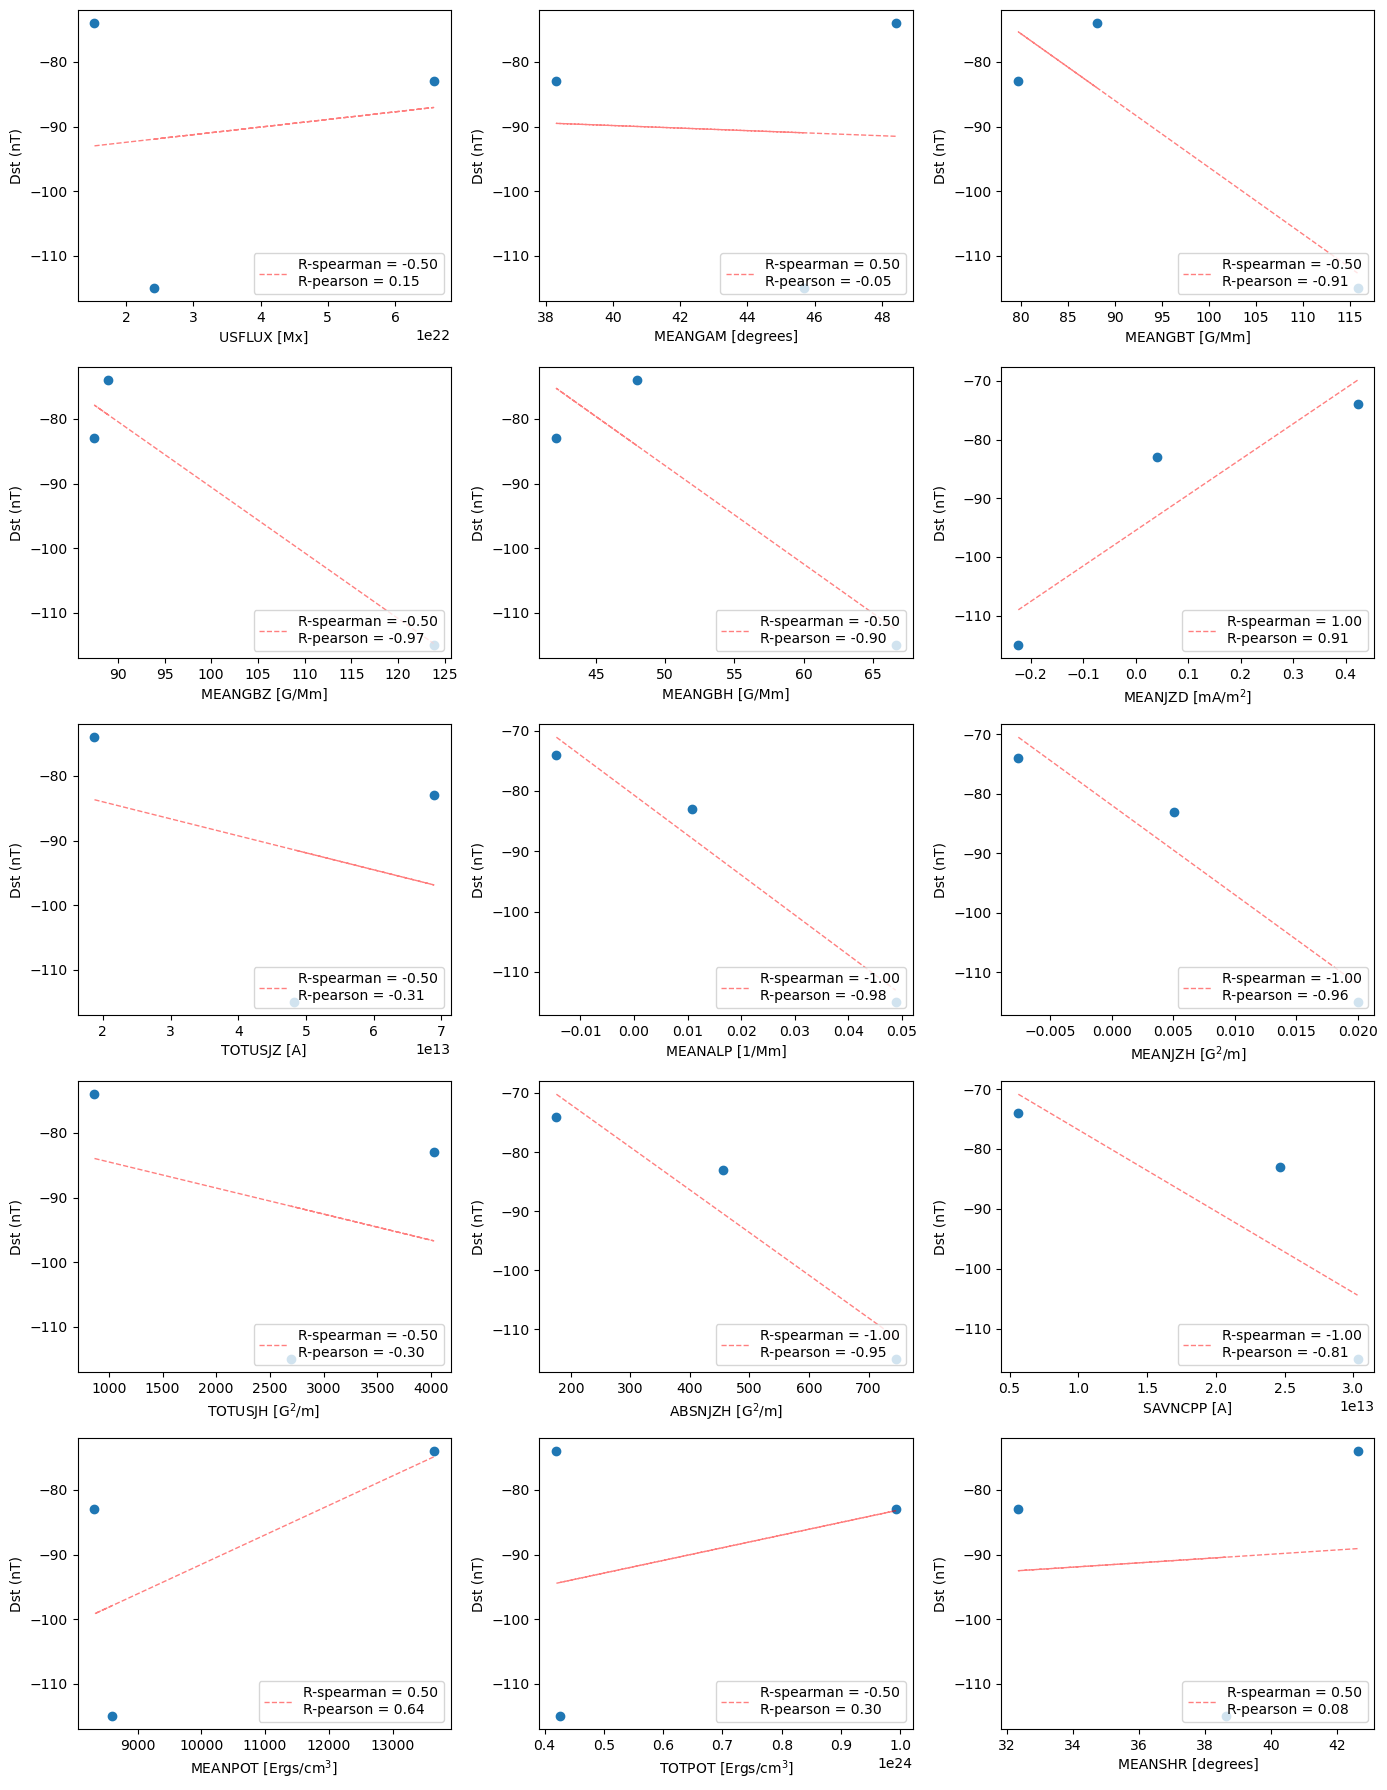

In [61]:
fig = plt.figure(figsize=[14,18])

for i, key in enumerate(keys):
    ax = fig.add_subplot(5,3,i+1)

    # Calculate linear fit
    m, b = np.polyfit(df[key], df['Dst'], 1)

    # Calculate correlation coefficients
    spearman_corr, _ = spearmanr(df[key], df['Dst'])
    pearsonr_corr, _ = pearsonr(df[key], df['Dst'])
    ax.plot(df[key], m*df[key] + b, c='red', ls='--', lw='1', alpha=0.5, label=f'R-spearman = {spearman_corr:.2f}\nR-pearson = {pearsonr_corr:.2f}')

    ax.scatter(df[key], df['Dst'])
    ax.set_ylabel('Dst (nT)')
    ax.legend(loc='lower right')

    if key == f'USFLUX':
        ax.set_xlabel(f'{key} [Mx]')
    elif key == f'MEANGAM' or key == f'MEANSHR':
        ax.set_xlabel(f'{key} [degrees]')
    elif key == f'MEANGBZ' or key == f'MEANGBH' or key == f'MEANGBT':
        ax.set_xlabel(f'{key} [G/Mm]')
    elif key == f'MEANJZD':
        ax.set_xlabel(f'{key} [mA/m$^2$]')
    elif key == f'TOTUSJZ' or key == f'SAVNCPP':
        ax.set_xlabel(f'{key} [A]')
    elif key == f'MEANALP':
        ax.set_xlabel(f'{key} [1/Mm]')
    elif key == f'MEANJZH' or key == f'TOTUSJH' or key == f'ABSNJZH':
        ax.set_xlabel(f'{key} [G$^2$/m]')
    elif key == f'MEANPOT' or key == f'TOTPOT':
        ax.set_xlabel(f'{key} [Ergs/cm$^3$]')

fig.tight_layout()
# fig.savefig(f'./{filename}_scatterplots_Dst.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### keys vs. CME speed

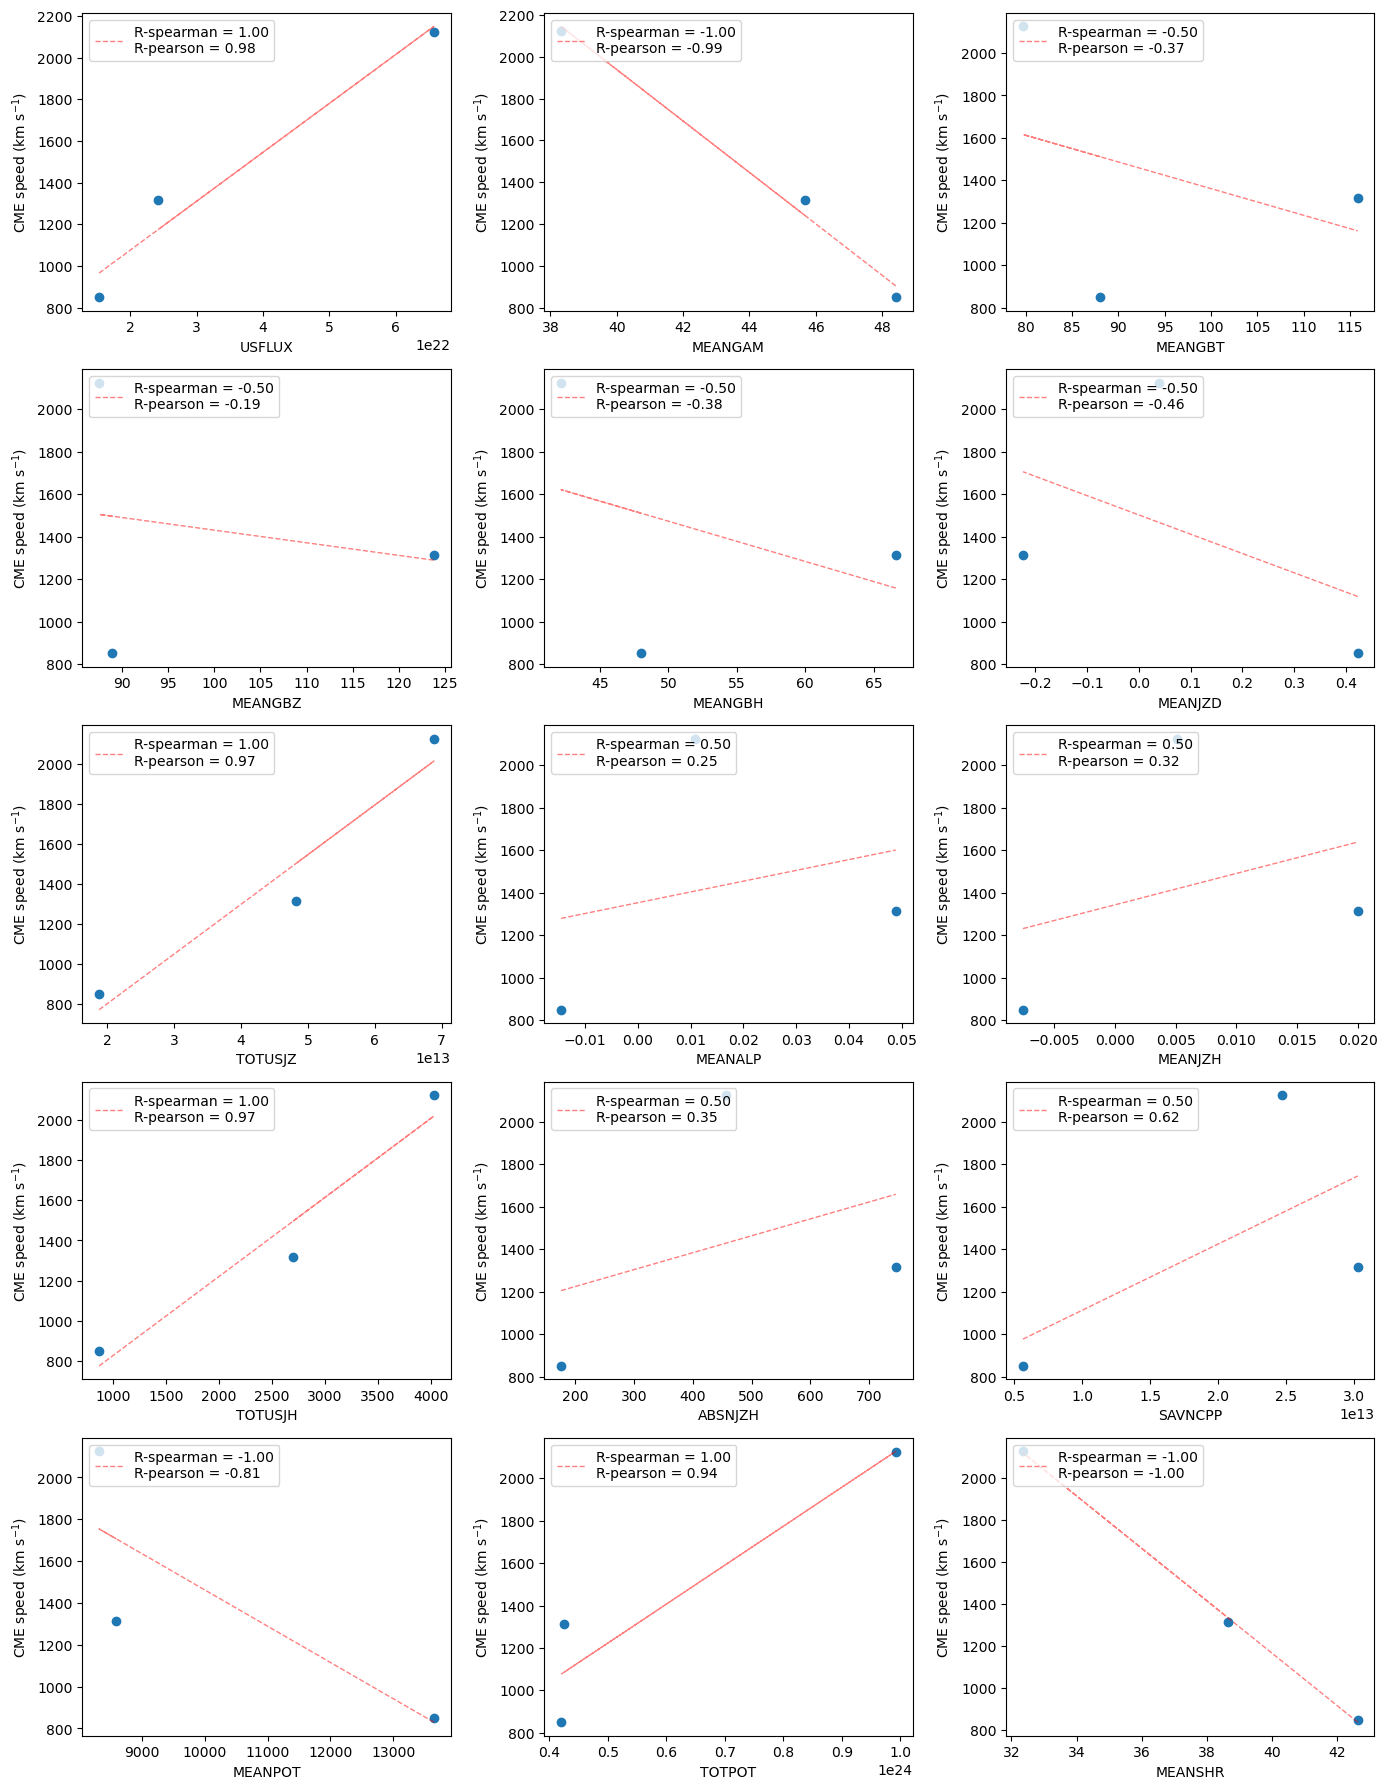

In [62]:
fig = plt.figure(figsize=[14,18])

for i, key in enumerate(keys):
    ax = fig.add_subplot(5,3,i+1)

    # Calculate linear fit
    m, b = np.polyfit(df[key], df['CME_speed'], 1)

    # Calculate correlation coefficients
    spearman_corr, _ = spearmanr(df[key], df['CME_speed'])
    pearsonr_corr, _ = pearsonr(df[key], df['CME_speed'])
    ax.plot(df[key], m*df[key] + b, c='red', ls='--', lw='1', alpha=0.5, label=f'R-spearman = {spearman_corr:.2f}\nR-pearson = {pearsonr_corr:.2f}')

    ax.scatter(df[key], df['CME_speed'])
    ax.set_xlabel(f'{key}')
    ax.set_ylabel('CME speed (km s$^{-1}$)')
    ax.legend(loc='upper left')

fig.tight_layout()
# fig.savefig(f'./{filename}_scatterplots_CMEspeed.png', format='png', dpi=300, bbox_inches='tight')
plt.show()